<a href="https://www.kaggle.com/code/rubanzasilva/ps-s04-e03-fastai?scriptVersionId=169150404" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Imports

If you dont have the fastai library installed, uncomment the lines with pip install fastbook to install all the dependencies we shall need.

In [55]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)

# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import plot_importance

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

Set random seed for reproducibility.

In [3]:
#random.seed(42)
set_seed(42)

In [4]:
!ls

state.db


Import Dataset

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


In [6]:
!ls /kaggle/input/playground-series-s4e3

sample_submission.csv  test.csv  train.csv


In [7]:
path = Path('/kaggle/input/playground-series-s4e3')
path

Path('/kaggle/input/playground-series-s4e3')

Read in Datasets

In [8]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sub_df = pd.read_csv(path/'sample_submission.csv')

In [20]:
train_df.shape,test_df.shape

((19219, 35), (12814, 28))

Missing Value Check

In [18]:
train_df.isna().sum()

id                       0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

Long Tail Distributions

When we look at our columns, we notice that our targets all have long tail distributions.

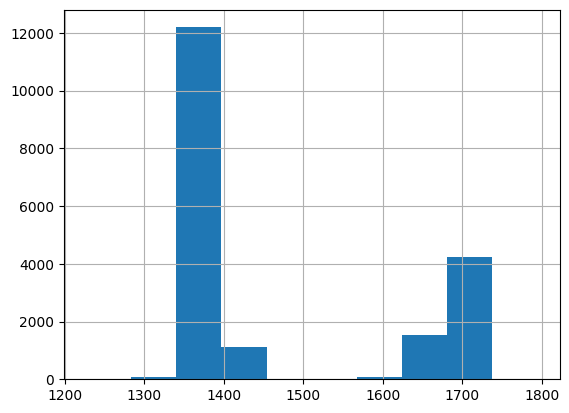

In [31]:
train_df['Length_of_Conveyer'].hist();

In [ ]:
Take Log of Long tail distributions
Targets
Length og conveyor

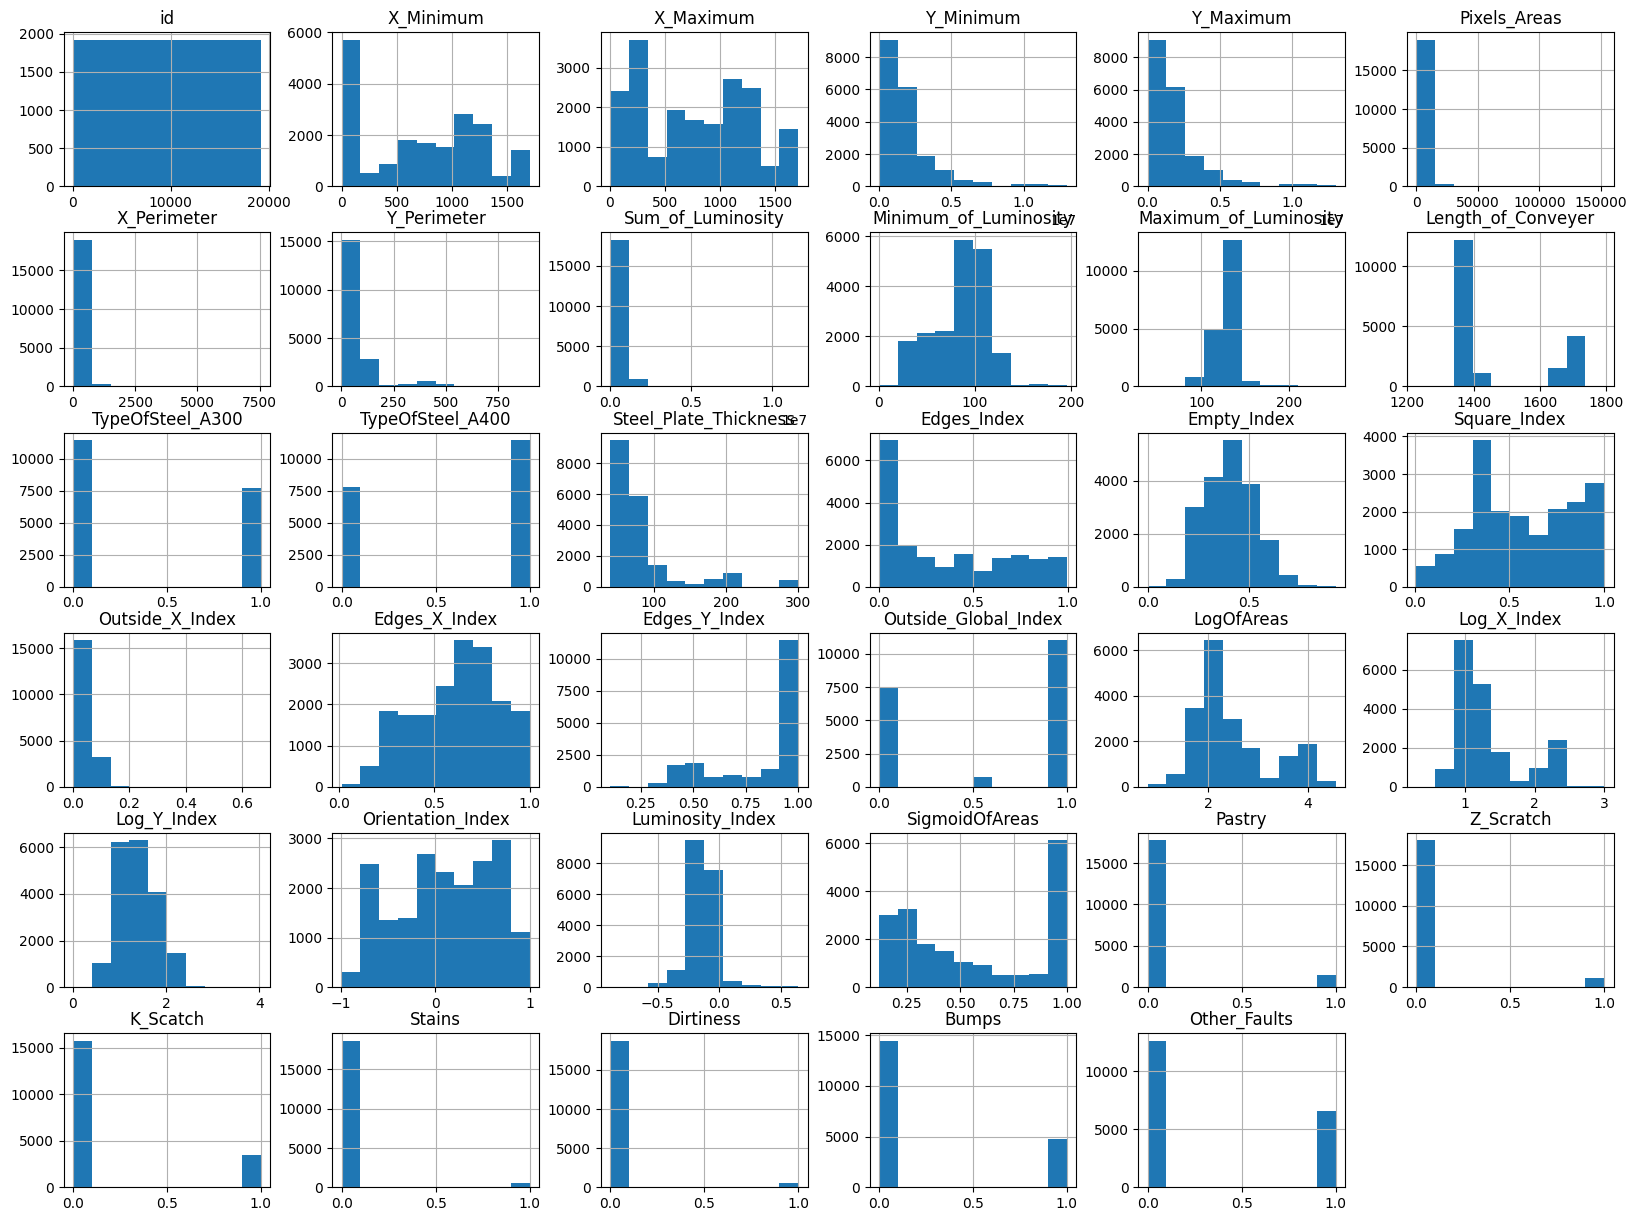

In [26]:
train_df.hist(figsize=(20, 15));

In [9]:
test_df.shape,train_df.shape

((12814, 28), (19219, 35))

Lets create a list called y_names of our dependent variables / targets

In [10]:
y_names = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
cont_names, cat_names = cont_cat_split(train_df,dep_var=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

### TabularPandas Object

We create an instance of a TabularPandas Object,to which is a fastai dataframe wrapper that stores all the information about our dataset such as which columns are continous, categorical, and our dependent variables. 

This instance also stores and applies the set transformations to our data.

In [11]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names= y_names,
                  # y_block = CategoryBlock,
                   splits=splits)

In [12]:
to.xs.iloc[:2]

,TypeOfSteel_A300,TypeOfSteel_A400,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
11340,2,1,0.313684,-1.340465,-1.486213,-0.721962,-0.722446,-0.424463,-0.376291,-0.406758,...,-0.399167,0.144737,0.062912,0.842607,-0.567453,-0.230852,-0.068816,0.865095,-1.070323,-0.595141
2094,1,2,-1.356317,1.151727,1.173838,2.113786,2.123421,-0.270663,-0.348350,-0.276931,...,-0.373550,-0.409438,0.761681,0.842607,0.536130,0.064983,0.412268,0.324788,-0.468295,1.215455


### DataLoaders
We now go ahead and create a dataloaders object which loads the data in a given batch size. Before loading the data the transforms are applied.

In [34]:
dls = to.dataloaders(bs=64)

In [35]:
dls.show_batch()

,TypeOfSteel_A300,TypeOfSteel_A400,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,1,0,17982.000226,507.000007,512.999994,1.620649e+06,1.620667e+06,113.999989,17.000000,14.999999,13986.995683,105.000000,140.0,1687.999994,70.000000,0.0036,0.3667,0.6667,0.0077,0.7647,1.0000,1.000000e+00,2.0569,1.1139,1.1761,3.333000e-01,-0.0548,0.3097,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,6071.000139,1327.000014,1332.000010,1.060291e+06,1.060313e+06,55.000038,20.999999,13.999999,4108.000022,86.000000,111.0,1687.999994,70.000000,0.0192,0.2917,0.5714,0.0044,0.3636,1.0000,1.000000e+00,1.7404,0.7782,1.1461,4.286000e-01,-0.1880,0.2195,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,1,13944.999971,38.999985,216.000022,2.896951e+06,2.897015e+06,6421.999874,278.000005,134.000000,670952.022029,41.999998,125.0,1358.000002,40.000001,0.0574,0.4603,0.3864,0.1289,0.6295,0.4925,-1.942094e-08,3.8084,2.2430,1.8325,-6.136000e-01,-0.1851,1.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0,8832.000038,52.000006,91.999997,6.825898e+04,6.828804e+04,313.000012,52.000001,41.000000,39555.995577,92.000000,133.0,1354.000004,70.000000,0.1064,0.6098,0.8947,0.0242,0.5165,0.5366,-1.942094e-08,2.4969,1.6128,1.3424,-1.053000e-01,-0.1166,0.9681,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0,9931.000006,1328.999997,1339.000025,3.485560e+05,3.485680e+05,139.999960,18.999999,28.999999,16070.002307,110.000000,133.0,1363.999996,199.999996,0.7699,0.5185,0.8571,0.0118,0.8947,0.5185,1.000000e+00,2.1461,1.2041,1.1461,1.429000e-01,-0.0786,0.3601,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0,1,1165.000239,630.000003,649.000001,2.339660e+06,2.339663e+06,54.000005,9.000002,9.000001,6935.994947,111.000001,142.0,1387.000000,40.000001,0.6333,0.2778,0.8889,0.0058,0.8889,1.0000,1.000000e+00,1.7324,0.9031,0.9542,1.111000e-01,-0.0236,0.1773,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0,1,8295.000025,1465.000030,1486.000029,2.601240e+05,2.601360e+05,54.000005,27.000002,12.000002,7483.998348,115.999999,140.0,1651.999996,40.000001,0.2668,0.5833,0.4000,0.0132,0.5556,0.5833,-1.942094e-08,1.7324,1.2553,0.8451,-6.000001e-01,-0.0041,0.2621,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,1,11864.000002,40.999969,211.999971,1.469856e+06,1.469884e+06,6881.999970,275.999995,131.000000,674367.004897,41.000001,124.0,1359.999997,40.000001,0.0604,0.4272,0.3829,0.1274,0.6604,0.4574,-1.942094e-08,3.8236,2.2380,1.8451,-6.171000e-01,-0.1851,1.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1,0,13140.000028,1064.999993,1078.000003,5.303273e+06,5.303295e+06,108.000013,18.999999,14.999999,12304.000938,97.000000,133.0,1363.999996,80.000000,0.7094,0.3536,1.0000,0.0089,0.6842,0.8667,5.000000e-01,2.0334,1.1139,1.1139,-2.434815e-09,-0.1094,0.2914,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1,0,18436.999806,40.999969,216.000022,1.853169e+06,1.853339e+06,654.999986,76.000000,133.000000,677554.017510,38.000001,124.0,1355.999999,80.000000,0.0605,0.4331,0.3771,0.1291,0.5369,0.5149,-1.942094e-08,2.8142,2.2430,1.8129,-6.229000e-01,-0.1902,1.0000,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Tabular Model

We can define our model by using the tabular_learner method which returns a learner that includes a tabularModel which creates a basic model for our tabular data while infering the right loss function.

In [36]:
learn = tabular_learner(dls, metrics=RocAucMulti())

SuggestedLRs(slide=0.019054606556892395, valley=0.0005754399462603033)

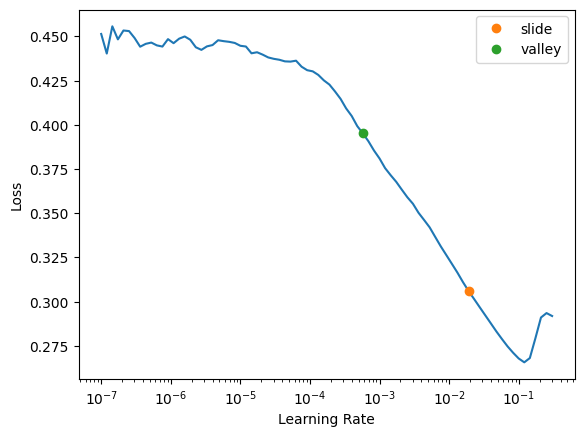

In [37]:
learn.lr_find(suggest_funcs=(slide,valley))

In [38]:
#learn.fit_one_cycle(15, slice(0.0005, 0.019))
learn.fit_one_cycle(12, 0.014)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.086378,0.086055,0.833141,00:02
1,0.083285,0.082288,0.813697,00:02
2,0.079279,0.079321,0.860916,00:02
3,0.076569,0.075957,0.849285,00:02
4,0.075968,0.074772,0.859882,00:02
5,0.076042,0.074590,0.868067,00:02
6,0.075415,0.074334,0.866360,00:02
7,0.074086,0.073945,0.866613,00:02
8,0.072482,0.073800,0.868766,00:02
9,0.071916,0.073627,0.867267,00:02


In [39]:
learn.show_results()

,TypeOfSteel_A300,TypeOfSteel_A400,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,Pastry_pred,Z_Scratch_pred,K_Scatch_pred,Stains_pred,Dirtiness_pred,Bumps_pred,Other_Faults_pred
0,1.0,2.0,1.229060,-1.267110,-1.086205,0.558758,0.562838,1.219324,1.199583,0.771679,0.961418,-1.249645,-0.120608,-0.707954,-0.671772,-0.927156,1.461232,-0.692141,2.068613,0.139793,-1.751434,-1.234495,1.733519,1.980748,1.046627,-1.457754,-0.331092,1.289203,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.007748,0.011762,0.916361,-0.001019,-0.003880,0.007568,0.077416
1,1.0,2.0,1.495112,-1.161779,-1.174207,-0.569277,-0.569185,-0.424734,-0.286880,-0.286917,-0.409382,1.146062,0.441885,-0.666694,1.814365,-0.646254,1.152790,-0.013436,-0.055471,0.460702,-1.735542,-1.234495,-0.572716,0.572802,-0.860653,-1.095906,0.830557,-0.465705,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.027791,0.105087,0.036282,-0.002561,0.009750,0.113227,0.628786
2,1.0,2.0,-1.405084,-1.310370,-1.464213,5.041518,5.061626,-0.438297,-0.465703,-0.556560,-0.416389,1.180782,0.793443,-0.494778,-0.671772,-1.099898,-0.002262,0.353650,-0.563544,-0.142014,0.761681,0.842607,-0.923473,-0.998784,-1.202554,0.468746,1.128245,-1.113486,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.047023,0.038815,0.083551,0.045646,0.051869,0.178273,0.450840
3,1.0,2.0,-1.513816,-0.204401,-0.250189,0.609885,0.614146,-0.397609,-0.320409,-0.346838,-0.370270,1.007180,0.371573,-0.666694,-0.671772,-0.770403,0.874067,-0.222209,-0.352203,-0.912825,-0.063765,-1.234495,-0.200776,-0.071277,0.180131,-1.207212,0.972749,-0.552397,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000484,0.055883,0.098458,0.000008,0.013580,0.252541,0.506221
4,1.0,2.0,1.084565,1.091538,1.119837,-0.817302,-0.818145,-0.365330,-0.348350,-0.316878,-0.356707,0.486374,0.371573,-0.728584,-0.119297,-1.066666,0.162401,-0.524969,-0.461075,0.102489,0.620020,0.842607,0.039070,-0.498024,0.251824,0.937177,0.190278,1.221174,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.091346,0.259167,-0.026925,0.011565,0.073395,0.264457,0.294337
5,2.0,1.0,0.580097,-0.292804,-0.378192,0.614171,0.618445,-0.431787,-0.460114,-0.486652,-0.411846,0.486374,-0.261231,1.588842,-0.119297,1.082418,-1.205507,0.353650,-0.525118,0.693519,0.761681,0.842607,-0.728359,-0.667440,-0.527651,0.468746,0.086336,-0.920236,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.119006,-0.001774,0.004945,0.003758,0.004630,0.531877,0.312753
6,1.0,2.0,-0.141656,-1.267110,-1.088206,-0.187156,-0.185717,1.454770,1.009584,0.791653,1.213140,-1.631569,-0.331543,-0.694201,-0.671772,-0.927469,0.156779,-0.683667,2.036592,0.106983,-1.651545,-1.234495,1.746282,1.970053,1.171225,-1.453236,-0.398446,1.289203,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.004734,0.001276,0.963272,0.004722,-0.003429,-0.004383,0.036174
7,2.0,1.0,-0.605304,-0.153617,-0.228189,0.095545,0.098013,-0.398965,-0.432173,-0.456692,-0.378082,1.215503,0.793443,-0.680447,0.433178,1.967446,0.905393,0.504645,-0.461075,0.232830,0.227729,0.842607,-0.214591,-0.498024,-0.393165,0.388244,1.377704,-0.287204,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.002585,0.023583,-0.006157,0.023420,0.044398,0.435490,0.408624
8,1.0,2.0,-0.765513,-1.267110,-1.128206,3.084261,3.097390,0.738123,0.663115,0.462090,0.644310,-1.631569,0.793443,-0.694201,-0.671772,-0.915243,-0.083388,-0.766868,1.667278,0.949257,-1.372310,-1.234495,1.539853,1.860531,0.807074,-1.497594,-0.155639,1.289203,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.000519,-0.016479,0.940702,-0.012248,0.001375,0.012328,0.067675


In [40]:
dl = learn.dls.test_dl(test_df)

nn_preds = learn.get_preds(dl=dl)
nn_preds

(tensor([[ 0.4967, -0.0080,  0.0104,  ...,  0.0406,  0.0908,  0.3068],
         [ 0.2116,  0.0078,  0.0229,  ...,  0.2028,  0.0905,  0.3876],
         [-0.0062,  0.0281,  0.0600,  ...,  0.0142,  0.2503,  0.5351],
         ...,
         [-0.0157,  0.0076,  0.9403,  ..., -0.0107,  0.0017,  0.0751],
         [ 0.4326,  0.0199,  0.0362,  ...,  0.0354,  0.0998,  0.3093],
         [-0.0188,  0.0249,  0.9568,  ...,  0.0035, -0.0140,  0.0464]]),
 None)

nn_preds returns the predictions from the model

In [51]:
nn_preds_x = learn.get_preds()[0]
nn_preds_x

tensor([[ 6.9652e-02,  8.0843e-03,  7.7733e-02,  ..., -8.0417e-03,
          7.6947e-02,  6.6978e-01],
        [ 2.4433e-02,  1.1901e-01,  1.5449e-01,  ...,  1.5449e-02,
          1.3764e-01,  4.7478e-01],
        [ 1.1129e-01,  2.2417e-02,  3.8931e-02,  ..., -9.1550e-04,
          4.4821e-01,  3.3556e-01],
        ...,
        [ 2.8458e-02,  2.3791e-01,  2.0268e-02,  ...,  6.6702e-02,
          2.4797e-01,  3.5071e-01],
        [ 3.6283e-02,  6.9355e-01,  1.3539e-02,  ...,  5.2019e-04,
          7.6329e-02,  1.7384e-01],
        [ 1.9005e-01,  2.4666e-03, -2.9382e-04,  ..., -7.9378e-03,
          4.1715e-01,  3.8300e-01]])

In [53]:
roc_auc_score(y_test, nn_preds_x)

0.8701531818015955

We can create a submission file for our tabular_learner model by uncommenting and running the cell below.

In [ ]:
#target_preds = preds[0]
#targets =['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
#test_df[targets] = target_preds

#test_df.to_csv('submission.csv', columns=['id','Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], index=False)

#sub = pd.read_csv('submission.csv')
#sub.head()

### Neural Network Ensemble

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=RocAucMulti())
    with learn.no_bar(),learn.no_logging(): learn.fit(12, 0.014)
    return learn.get_preds(dl=dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
#targets =['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
#test_df[targets] = ens_preds

#test_df.to_csv('submission.csv', columns=['id','Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], index=False)

#ens_sub = pd.read_csv('submission.csv')
#ens_sub.head()

### Random Forests

In [13]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

roc_auc_score(y_test, rf.predict(X_test))

0.6609112622455683

In [57]:
rf_preds = rf.predict(X_test)
roc_auc_score(y_test, rf_preds)

0.6609112622455683

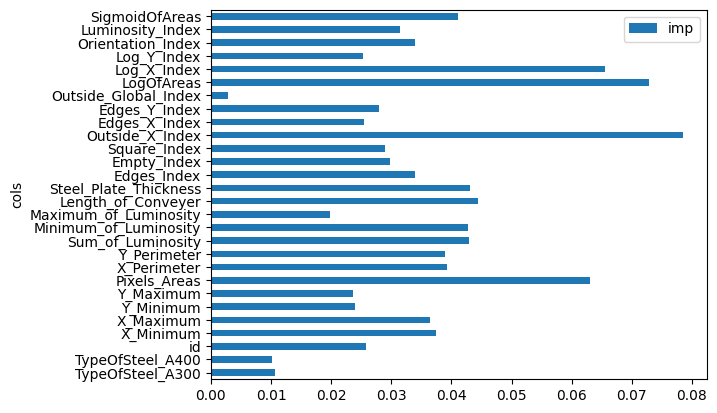

In [14]:
pd.DataFrame(dict(cols=X_train.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

### XGBoost

In [43]:
model = xgb.XGBClassifier(n_estimators = 100, max_depth=8, learning_rate=0.1, subsample=0.5)

In [44]:
xgb_model = model.fit(X_train, y_train)

In [45]:
xgb_preds = xgb_model.predict_proba(X_test)

In [46]:
roc_auc_score(y_test, xgb_preds)

0.8713379050136527

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

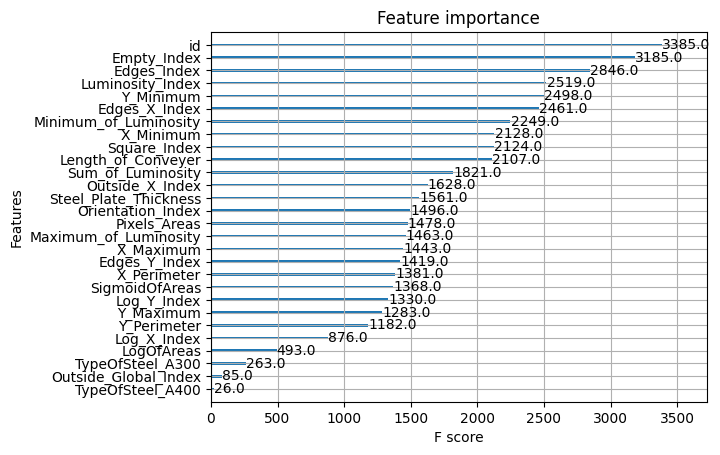

In [56]:
plot_importance(xgb_model)

# General Ensemble

In [58]:
avgs = (nn_preds_x + xgb_preds + rf_preds ) / 3
avgs

tensor([[ 4.5112e-02,  3.0548e-03,  2.7245e-02,  ..., -1.9092e-03,
          6.1382e-02,  7.6518e-01],
        [ 8.7169e-03,  1.8100e-01,  5.5874e-02,  ...,  9.9623e-03,
          8.0087e-02,  3.0430e-01],
        [ 4.8192e-02,  1.3605e-02,  1.3229e-02,  ..., -1.4187e-04,
          2.5648e-01,  1.6115e-01],
        ...,
        [ 1.0548e-02,  9.1369e-02,  7.1713e-03,  ...,  2.3633e-02,
          2.1250e-01,  6.8077e-01],
        [ 1.6592e-02,  8.4101e-01,  4.6162e-03,  ...,  8.3496e-04,
          3.8612e-02,  1.2229e-01],
        [ 1.3484e-01,  1.0448e-03,  5.2368e-05,  ..., -2.4340e-03,
          3.1131e-01,  2.3692e-01]])

In [59]:
avgs.shape

torch.Size([3843, 7])

In [60]:
roc_auc_score(y_test, avgs)

0.8754313204050119

Our general ensemble returns a higher roc_auc_score which results in the best score.

### Kaggle Submission

In [ ]:
#preds = rf.predict(X_test)

# Assuming `test_df` is your test DataFrame and it has an 'id' column
# Create a DataFrame for the submission
sub_df = pd.DataFrame(preds, columns=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])
sub_df['id'] = test_df['id'] # Add the 'id' column from the test data

# Reorder the columns to match the submission format
sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
sub_df.to_csv('submission.csv', index=False)

General Ensemble Submission

In [ ]:
#preds = rf.predict(X_test)

# Assuming `test_df` is your test DataFrame and it has an 'id' column
# Create a DataFrame for the submission
sub_df = pd.DataFrame(avgs, columns=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])
sub_df['id'] = test_df['id'] # Add the 'id' column from the test data

# Reorder the columns to match the submission format
sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
sub_df.to_csv('submission.csv', index=False)

In [ ]:
# Assuming `rf` is your trained model and `X_test` is your test data
# Make predictions
preds = rf.predict(X_test)

# Assuming `test_df` is your test DataFrame and it has an 'id' column
# Create a DataFrame for the submission
sub_df = pd.DataFrame(preds, columns=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])
sub_df['id'] = test_df['id'] # Add the 'id' column from the test data

# Reorder the columns to match the submission format
sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
sub_df.to_csv('submission.csv', index=False)


In [ ]:
!ls

In [ ]:
# Assuming `sub_df` is your DataFrame that needs the 'id' column converted
# Convert 'id' column to Int32 by rounding the floating-point numbers
#submission_df['id'] = submission_df['id'].round().astype('Int32')

# Now, 'id' column is of type Int32
#print(submission_df['id'].dtype)


In [ ]:
# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission1.csv', index=False)

In [ ]:
!ls

In [ ]:
#sub_df = pd.read_csv(path/'sample_submission.csv')
sub_tree = pd.read_csv('submission2.csv')

In [ ]:
sub_tree.info()

In [ ]:
sub_df

In [ ]:
print(sub_df['id'].dtype)

In [ ]:
#target_preds = preds[0]
#target_preds

Submit Outside Kaggle.

In [ ]:
#!kaggle competitions submit -c playground-series-s4e3 -f submission.csv -m "fastai baseline, adding lr fron lr finder"

Full Notebook

In [ ]:
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
from fastai.tabular.all import *

from fastai.imports import *
np.set_printoptions(linewidth=130)

# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path
import os
import seaborn as sns
import numpy as np
from numpy import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from ipywidgets import interact



matplotlib.rc('image', cmap='Greys')

random.seed(42)

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

path = Path('/kaggle/input/playground-series-s4e3')
path

train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sub_df = pd.read_csv(path/'sample_submission.csv')

y_names = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

cont_names, cat_names = cont_cat_split(train_df,dep_var=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])

splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names= y_names,
                  # y_block = CategoryBlock,
                   splits=splits)

#X_train, y_train = to.train.xs, to.train.ys.values.ravel()
#X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

roc_auc_score(y_test, rf.predict(X_test))

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

path = Path('/kaggle/input/playground-series-s4e3')
path

train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sub_df = pd.read_csv(path/'sample_submission.csv')

y_names = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

cont_names, cat_names = cont_cat_split(train_df,dep_var=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])

splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names= y_names,
                  # y_block = CategoryBlock,
                   splits=splits)

dls = to.dataloaders(bs=64)

dl = learn.dls.test_dl(test_df)

learn = tabular_learner(dls, metrics=RocAucMulti())

#learn.fit_one_cycle(15, slice(0.0005, 0.019))
learn.fit_one_cycle(12, 0.014)


preds = learn.get_preds(dl=dl)


target_preds = preds[0]
targets =['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
test_df[targets] = target_preds

test_df.to_csv('submission.csv', columns=['id','Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], index=False)

#sub = pd.read_csv('submission.csv')
#sub.head()